In [ ]:
!unzip '/content/Roads.v3i.coco-segmentation.zip'

Archive:  /content/Roads.v3i.coco-segmentation.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/4_jpg.rf.5a0403b4e312b49d8a1a76ab2268d8f7.jpg  
 extracting: test/_annotations.coco.json  
   creating: train/
 extracting: train/10_jpg.rf.cbefeae1444599761d4a87c6a8c2bdda.jpg  
 extracting: train/11_jpg.rf.4aafd416d2da16bc5898511fd0f6bae6.jpg  
 extracting: train/12_jpg.rf.77d7ca9c2128869476b796487afbe58e.jpg  
 extracting: train/1_jpg.rf.7f9935c1863bcd1e0d8f31cb28811df0.jpg  
 extracting: train/3_jpg.rf.78c4590b51044394b99930b014bb7b6f.jpg  
 extracting: train/5_jpg.rf.65db1f1f3442cec9122368db2c39652c.jpg  
 extracting: train/6_jpg.rf.89154f655b2464d9bc3b7ec79a570e24.jpg  
 extracting: train/7_jpg.rf.7680b1f168fe7570a1ce24c10389b32a.jpg  
 extracting: train/8_jpg.rf.496ed886c9e3ee3a81338bc1690e5faa.jpg  
 extracting: train/9_jpg.rf.24189ddf1adb4ffc8e7c8102ccbd1665.jpg  
 extracting: train/_annotations.coco.json  
   creat

In [ ]:
from pycocotools.coco import COCO
import os
from matplotlib import image
from pathlib import Path


In [ ]:
img_dir = "/content/train"
annFile = os.listdir("/content/train/")


In [ ]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Get category IDs and annotation IDs
catIds = coco.getCatIds()
annsIds = coco.getAnnIds()

In [ ]:
catIds

[0, 1]

In [ ]:
annsIds

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
# Create folders named after annotation categories
for cat in catIds:
    Path(os.path.join("./your_output_folder",coco.loadCats(cat)[0]['name'])).mkdir(parents=True, exist_ok=True)

In [ ]:
for ann in annsIds:
    # Get individual masks
    mask = coco.annToMask(coco.loadAnns(ann)[0])
    # Save masks to BW images
    file_path = os.path.join("./your_output_folder",coco.loadCats(coco.loadAnns(ann)[0]['category_id'])[0]['name'],coco.loadImgs(coco.loadAnns(ann)[0]['image_id'])[0]['file_name'])
    image.imsave(file_path, mask, cmap="gray")

In [ ]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
Learning_Rate=1e-5
width=height=800 # image width and height
batchSize=3

In [ ]:
TrainFolder="/content/train/"
ListImages= os.listdir("/content/train/")


In [ ]:
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)), tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)), tf.ToTensor()])

In [ ]:
Learning_Rate=1e-5
width=height=800 # image width and height
batchSize=3

In [ ]:
def ReadRandomImage(): 
  idx=np.random.randint(0,len(ListImages)) # Pick random image 
  Img = cv2.imread(os.path.join(TrainFolder,ListImages[idx]))  
  Ann =  cv2.imread(os.path.join("/content/your_output_folder/Roads/", ListImages[idx]),0)              
  AnnMap = np.zeros(Img.shape[0:2],np.float32) # Segmentation map  
  AnnMap[ Ann != 0 ] = 255
  Img=transformImg(Img)
  AnnMap=transformAnn(AnnMap)
  return Img,AnnMap

In [ ]:
idx = np.random.randint(0,len(ListImages)) # Pick random image
Img = cv2.imread(os.path.join(TrainFolder,ListImages[idx]))

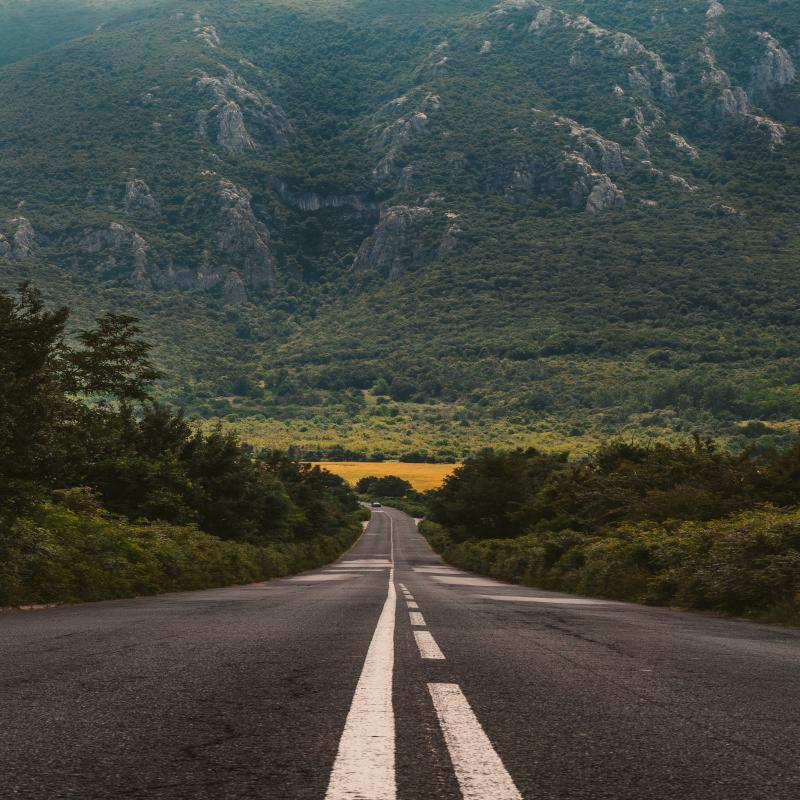

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(Img)

In [ ]:
Ann =  cv2.imread(os.path.join("/content/your_output_folder/Roads/", ListImages[idx]),0)       

In [ ]:
np.unique(AnnMap)

array([  0., 255.], dtype=float32)

In [ ]:
AnnMap = np.zeros(Img.shape[0:2],np.float32)

In [ ]:
AnnMap[ Ann != 0 ] = 255

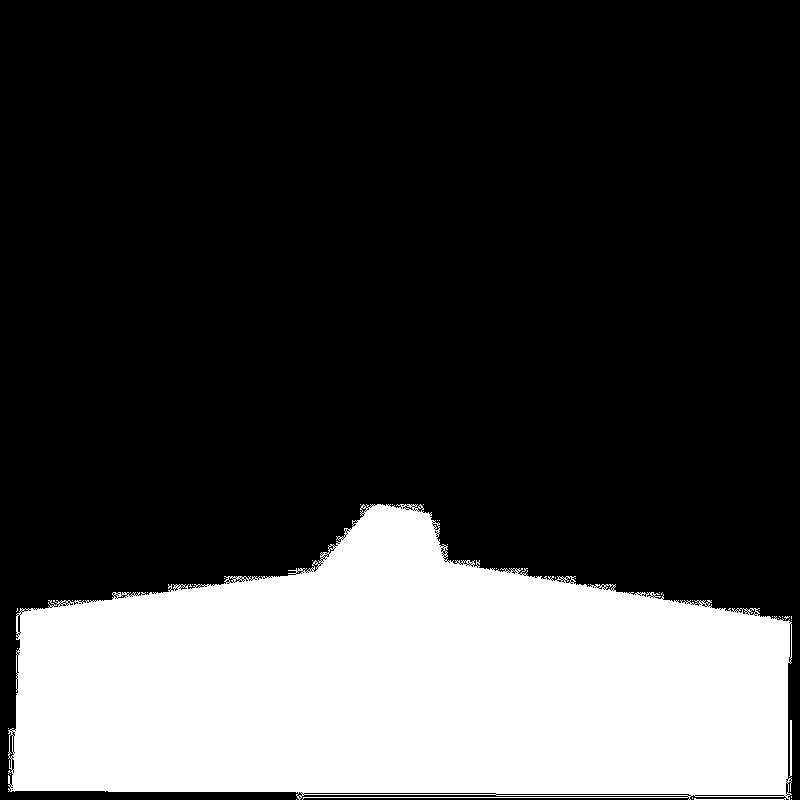

In [ ]:
cv2_imshow(AnnMap)

In [ ]:
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    
    return images, ann

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
Net.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to 3 classes
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [ ]:
for itr in range(10000): # Training loop
   images,ann=LoadBatch() # Load taining batch
   images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
   ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
   Pred=Net(images)['out'] # make prediction
   Net.zero_grad()
   criterion = torch.nn.CrossEntropyLoss() # Set loss function
   Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
   Loss.backward() # Backpropogate loss
   optimizer.step() # Apply gradient descent change to weight
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
   print(itr,") Loss=",Loss.data.cpu().numpy())
   if itr % 1000 == 0: #Save model weight once every 60k steps permenant file
        print("Saving Model" +str(itr) + ".torch")
        torch.save(Net.state_dict(),   str(itr) + ".torch")

IndexError: ignored